In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import queue
import contextlib
import time
import PyQt5

In [2]:
# pip install PyQt5

#### Import the logs (backlog + incoming) from .CSV and create DataFrame

In [152]:
backlog_df = pd.read_csv('defectRemediation_log_simulation_vPrototype_v2.csv', index_col='ID')
backlog_df['Timestamp'] = pd.to_datetime(backlog_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# backlog_df
incoming_log_df = pd.read_csv('defectRemediation_log_incoming_simulation_vPrototype.csv', index_col='ID')
incoming_log_df['Timestamp'] = pd.to_datetime(incoming_log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# incoming_log_df

In [153]:
class logEntry:
    def __init__(self, defect_id, state, control_type, sub_backlog_df):
        self.defect_id = defect_id
        self.state = state
        self.control_type = control_type
        self.sub_backlog_df = sub_backlog_df

    # def stateNew(self):
    ## create new delta table row

    def stateAssign(self, empirical_dict):
        timestamp_new = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_assign = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between assign and new (hrs)
        delta_new_assign = self.computeDelta(timestamp_new, timestamp_assign)

        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_new_assign'].append(delta_new_assign)
        return delta_new_assign, empirical_dict

    def stateInProgress(self, empirical_dict):
        timestamp_assign = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']=='assign')]['Timestamp'].iloc[0]
        timestamp_inprogress = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between in-progress and assign (hrs)
        delta_assign_inprogress = self.computeDelta(timestamp_assign, timestamp_inprogress)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_assign_inprogress'].append(delta_assign_inprogress)
        return delta_assign_inprogress, empirical_dict

    def stateClosed(self, empirical_dict):
        timestamp_new = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_inprogress = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']=='in-progress')]['Timestamp'].iloc[0]
        timestamp_closed = sub_backlog_df.loc[(sub_backlog_df['Defect_ID']==self.defect_id) & (sub_backlog_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between closed and in-progress, and closed and new (hrs)
        delta_inprogress_closed = self.computeDelta(timestamp_inprogress, timestamp_closed)
        delta_new_closed = self.computeDelta(timestamp_new, timestamp_closed)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_inprogress_closed'].append(delta_inprogress_closed)
        empirical_dict[self.control_type]['delta_new_closed'].append(delta_new_closed)
        return delta_inprogress_closed, delta_new_closed, empirical_dict

    # def updateDeltaTable(self, delta_state_state):
    def computeDelta(self, timestamp_older, timestamp_newer):
        ## Computes the time delta (in hrs) as timestamp_newer - timestamp_older
        delta_timestamps = timestamp_newer - timestamp_older
        delta_timestamps = round(delta_timestamps.total_seconds()/3600, 3)
        return delta_timestamps

    def updateFigure(self, sub_deltas_df):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs[0].plot(range(1,len(sub_deltas_df['Delta_New_Assign'])+1), sub_deltas_df['Delta_New_Assign'], 'k-o', markersize=6)
        axs[0].set_ylabel('time (hrs)')
        axs[0].set_title('Delta_New_Assign', loc='left', fontsize=10)

        axs[1].plot(range(1,len(sub_deltas_df['Delta_Assign_InProgress'])+1), sub_deltas_df['Delta_Assign_InProgress'], 'k-o', markersize=6)
        axs[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)

        axs[2].plot(range(1,len(sub_deltas_df['Delta_InProgress_Closed'])+1), sub_deltas_df['Delta_InProgress_Closed'], 'k-o', markersize=6)
        axs[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)

        axs[3].plot(range(1,len(sub_deltas_df['Delta_New_Closed'])+1), sub_deltas_df['Delta_New_Closed'], 'k-o', markersize=6)
        axs[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
    
        fig.text(0.5, 0.95, f'{self.control_type}', ha='center', fontsize=12)
        plt.savefig(f'{self.control_type}_fig.png', bbox_inches='tight')
        plt.close()

In [162]:
class buildDistributions:
    def __init__(self, empirical_dict):
        self.empirical_dict = empirical_dict

    # def deltaDistributions(self):

    def incomingDistributions(self, current_hour_backlog_df):
        for control_type in self.empirical_dict.keys():
            incoming_defects = len(current_hour_backlog_df.query('Control_Type == @control_type'))
            self.empirical_dict[control_type]['incoming_per_hour'].append(incoming_defects)
        return self.empirical_dict

In [127]:
empirical_dict

{'ACC03': {'incoming_per_hour': [],
  'delta_new_assign': [0.224,
   0.845,
   0.271,
   0.329,
   1.506,
   15.869,
   16.184,
   17.233,
   18.747,
   24.622],
  'delta_assign_inprogress': [0.063,
   0.466,
   0.206,
   3.382,
   2.044,
   0.028,
   3.04,
   1.986,
   1.334,
   45.928],
  'delta_inprogress_closed': [0.204,
   0.731,
   2.983,
   4.347,
   2.186,
   3.781,
   4.576,
   4.589,
   3.745,
   8.219],
  'delta_new_closed': [0.49,
   2.041,
   3.518,
   8.0,
   5.736,
   19.678,
   23.8,
   23.809,
   23.826,
   78.768]},
 'ACC17': {'incoming_per_hour': [],
  'delta_new_assign': [0.501, 1.597, 2.794, 1.504, 9.149, 9.281, 9.376],
  'delta_assign_inprogress': [0.503, 0.052, 22.522, 2.21, 2.112, 2.915, 4.837],
  'delta_inprogress_closed': [0.779,
   0.047,
   22.016,
   1.458,
   21.882,
   23.894,
   28.032],
  'delta_new_closed': [1.783, 1.696, 47.333, 5.173, 34.173, 35.287, 42.018]},
 'ACC28': {'incoming_per_hour': [],
  'delta_new_assign': [1.5, 2.271, 5.857],
  'delta_ass

In [97]:
row = 10
starting_point = backlog_df.index[0]

In [118]:
backlog_df

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0.0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0.0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0.0
4,1,ACC03,assign,2025-16-05,2025-05-16 00:18:57,0.0
5,1,ACC03,in-progress,2025-16-05,2025-05-16 00:22:43,0.0
...,...,...,...,...,...,...
112,29,ACC17,in-progress,2025-29-05,2025-05-29 12:05:29,12.0
113,27,ACC17,in-progress,2025-29-05,2025-05-29 13:47:03,13.0
114,29,ACC17,closed,2025-30-05,2025-05-30 09:58:24,9.0


In [126]:
current_hour_backlog_df = backlog_df.query('(Hour == 0) and (State=="new")')
len(current_hour_backlog_df.query('Control_Type == "AUTH42"'))

0

In [149]:
current_hour = backlog_df.iloc[105]['Timestamp']
current_hour

Timestamp('2025-05-28 23:47:56')

In [147]:
current_hour = backlog_df.iloc[105]['Timestamp']
current_hour += datetime.timedelta(hours=1)
current_hour
# current_hour.date()

Timestamp('2025-05-29 00:47:56')

In [136]:
current_hour.date() == backlog_df.loc[114, 'Timestamp'].date()

False

In [ ]:
backlog_df.loc[]

In [137]:
current_hour.hour

0

In [143]:
starting_point = backlog_df.index[0]
row = 25
current_hour_backlog_df = backlog_df.loc[starting_point:row-1]
current_hour_backlog_df

KeyError: 'False: boolean label can not be used without a boolean index'

In [163]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
control_types = backlog_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }

In [164]:
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])
# current_date = backlog_df.iloc[0]['Date'] # for computing incoming defects per hour distributions
# date = backlog_df.iloc[0]['Timestamp'] # for computing incoming defects per hour distributions 
starting_point = backlog_df.index[0]

for row in backlog_df.iterrows():
    ## Add new columns 'Date' and 'Hour' for tracking incoming defects per hour 
    backlog_df.loc[row[0], 'Date'] = backlog_df.loc[row[0]]['Timestamp'].date()
    backlog_df.loc[row[0], 'Hour'] = backlog_df.loc[row[0]]['Timestamp'].hour

    ## Extract the defect ID, state, and control type of the log entry, and any other entries with the same defect ID (sub_backlog_df)
    defect_id = backlog_df.loc[row[0], 'Defect_ID']
    state = backlog_df.loc[row[0], 'State']
    control_type = backlog_df.loc[row[0], 'Control_Type']
    # timestamp = backlog_df.loc[row[0], 'Timestamp']
    sub_backlog_df = backlog_df.query('Defect_ID == @defect_id')

    ## Initialize class logEntry
    log_entry = logEntry(defect_id, state, control_type, sub_backlog_df)

    if state == 'new':
        ## append to delta table with defect_ID and control_type
        try: ## deltas_df contains some entries, add onto it
            Last_ID_processed = deltas_df.index[-1]
            index = Last_ID_processed + 1
        except IndexError: ## deltas_df is empty, start from beginning
            index = 0 
        deltas_df.loc[index, ['Defect_ID', 'Control_Type']] = [defect_id, control_type]
        ####### Should deltas_df be passed to a method and updated in the class?
    
    if state =='assign':
        delta_new_assign, empirical_dict = log_entry.stateAssign(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_New_Assign'] = delta_new_assign
        
        # log_entry.updateDeltaTable(delta_new_assign, sub_deltas_df)
    
    elif state == 'in-progress':
        delta_assign_inprogress, empirical_dict = log_entry.stateInProgress(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_Assign_InProgress'] = delta_assign_inprogress
    
    elif state == 'closed':
        delta_inprogress_closed, delta_new_closed, empirical_dict = log_entry.stateClosed(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, ['Delta_InProgress_Closed', 'Delta_New_Closed']] = [delta_inprogress_closed, delta_new_closed]
        ## if state == 'closed', all deltas for a given defect have been computed - extract all rows with same control_type to 
        sub_deltas_df = deltas_df.query('Control_Type == @control_type').dropna()
        log_entry.updateFigure(sub_deltas_df) ## update the figure for this control type
        
    # update the distributions every time "Hour" or "Date" changes bewteen log entries
    # if (backlog_df.loc[row[0], 'Date'] != date.date()) or (backlog_df.loc[row[0], 'Hour'] != date.hour):
    if row[0] % 20 == 0:
        ### to do: extract all values up to starting_point not including current date and hour
        
        # print(row[0])
        # # current_hour_backlog_df = backlog_df.loc[starting_point:row[0]-1]
        # current_date = date.date()
        # current_hour = date.hour
        # current_hour_backlog_df = backlog_df.query('(Date == @current_date) and (Hour == @current_hour) and (State == "new")')
        # empty_days_passed
        # empty_hours_passed = backlog_df.loc[row[0], 'Hour']
        
        # current_distributions = buildDistributions(empirical_dict)
        # # buildDistributions.deltaDistributions()
        # empirical_dict = current_distributions.incomingDistributions(current_hour_backlog_df)

        # date = backlog_df.loc[row[0], 'Timestamp']
        # # date += datetime.timedelta(hours=1)
        # # current_date = backlog_df.loc[row[0], 'Date'] # advance current date forward to next date if applicable
        # # current_hour = backlog_df.loc[row[0], 'Hour'] # advance current hour forward to next hour if applicable
        # # stopping_point = row[0]
        

2025-05-16 00:05:31
2025-05-16 01:05:31
2025-05-16 02:05:31
2025-05-16 03:05:31
2025-05-16 04:05:31
2025-05-16 05:05:31
2025-05-16 06:05:31
2025-05-16 07:05:31
2025-05-16 08:05:31
2025-05-16 09:05:31
2025-05-16 10:05:31
2025-05-16 11:05:31
2025-05-16 12:05:31
2025-05-16 13:05:31
2025-05-16 14:05:31
2025-05-16 15:05:31
2025-05-16 16:05:31
2025-05-16 17:05:31
2025-05-16 18:05:31
2025-05-16 19:05:31
2025-05-16 20:05:31
2025-05-16 21:05:31
2025-05-16 22:05:31
2025-05-16 23:05:31
2025-05-17 00:05:31
2025-05-17 01:05:31
2025-05-17 02:05:31
2025-05-17 03:05:31
2025-05-17 04:05:31
2025-05-17 05:05:31
2025-05-17 06:05:31
2025-05-17 07:05:31
2025-05-17 08:05:31
2025-05-17 09:05:31
2025-05-17 10:05:31
2025-05-17 11:05:31
2025-05-17 12:05:31
2025-05-17 13:05:31
2025-05-17 14:05:31
2025-05-17 15:05:31
2025-05-17 16:05:31
2025-05-17 17:05:31
2025-05-17 18:05:31
2025-05-17 19:05:31
2025-05-17 20:05:31
2025-05-17 21:05:31
2025-05-17 22:05:31
2025-05-17 23:05:31
2025-05-18 00:05:31
2025-05-18 01:05:31


In [179]:
df = backlog_df[1:50].query('State=="new"')
df[(df['Date'] != '2025-05-17') and (df['Hour'] != 2)]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [174]:
(backlog_df.loc[41, 'Date'] - backlog_df.loc[39, 'Date']).days 

2

In [125]:
current_date = backlog_df.iloc[0]['Date'] # for computing incoming defects per hour distributions
current_hour = backlog_df.iloc[0]['Timestamp'].hour # for computing incoming defects per hour distributions 
backlog_df.query('(Date == @current_date) and (Hour == @current_hour) and (State == "new")')

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0.0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0.0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0.0


In [ ]:
# update figures method
# update distributions method

In [38]:
deltas_df.loc[29, ['Defect_ID', 'Control_Type', 'Delta_New_Assign', 'Delta_Assign_InProgress']] = [42, 'ACC03', 0.1, 0.1]
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed,Delta_New_Closed
0,1,ACC03,0.224,0.063,0.204,0.49
1,2,ACC17,0.501,0.503,0.779,1.783
2,3,ACC28,1.5,1.594,1.067,4.16
3,4,AUTH18,1.039,0.229,1.603,2.871
4,5,ACC03,0.845,0.466,0.731,2.041
5,6,AUTH42,0.378,0.029,0.092,0.499
6,7,ACC17,1.597,0.052,0.047,1.696
7,8,ACC03,0.329,0.206,2.983,3.518
8,9,ACC03,0.271,3.382,4.347,8.0
9,10,ACC03,1.506,2.044,2.186,5.736


In [40]:
sub_deltas_df = deltas_df.query('Control_Type == "ACC03"').dropna()

In [49]:
range(1,len(sub_deltas_df['Delta_New_Assign'])+1)

range(1, 11)

In [48]:
len(sub_deltas_df['Delta_New_Assign'])

10

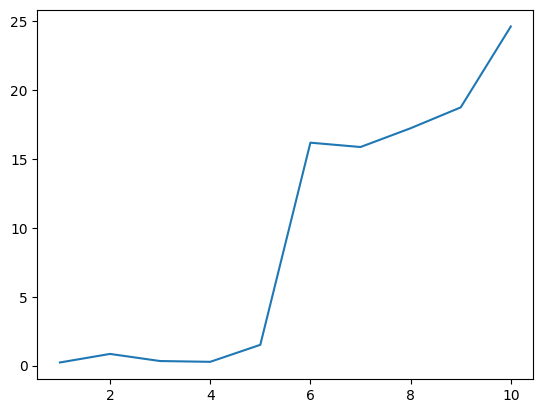

In [50]:
sub_deltas_df['Delta_New_Assign']
plt.plot(range(1,len(sub_deltas_df['Delta_New_Assign'])+1), sub_deltas_df['Delta_New_Assign'])

In [34]:
pd.isnull(deltas_df.iloc[29]['Delta_New_Closed'])

True

In [15]:
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed,Delta_New_Closed
0,1,ACC03,0.224,0.063,0.204,0.49
1,2,ACC17,0.501,0.503,0.779,1.783
2,3,ACC28,1.5,1.594,1.067,4.16
3,4,AUTH18,1.039,0.229,1.603,2.871
4,5,ACC03,0.845,0.466,0.731,2.041
5,6,AUTH42,0.378,0.029,0.092,0.499
6,7,ACC17,1.597,0.052,0.047,1.696
7,8,ACC03,0.329,0.206,2.983,3.518
8,9,ACC03,0.271,3.382,4.347,8.0
9,10,ACC03,1.506,2.044,2.186,5.736


In [19]:
backlog_df

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0.0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0.0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0.0
4,1,ACC03,assign,2025-16-05,2025-05-16 00:18:57,0.0
5,1,ACC03,in-progress,2025-16-05,2025-05-16 00:22:43,0.0
...,...,...,...,...,...,...
112,29,ACC17,in-progress,2025-29-05,2025-05-29 12:05:29,12.0
113,27,ACC17,in-progress,2025-29-05,2025-05-29 13:47:03,13.0
114,29,ACC17,closed,2025-30-05,2025-05-30 09:58:24,9.0


In [4]:
hours_backlog = []
hours_incoming = []
for row in backlog_df.iterrows():
    hours_backlog.append(backlog_df.loc[row[0]]['Timestamp'].hour)
for row in incoming_log_df.iterrows():
    hours_incoming.append(incoming_log_df.loc[row[0]]['Timestamp'].hour)
backlog_df['Hour'] = hours_backlog
incoming_log_df['Hour'] = hours_incoming
incoming_log_df

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
117,30,AUTH18,new,2025-30-05,2025-05-30 23:14:52,23
118,31,AUTH42,new,2025-30-05,2025-05-30 23:15:16,23
119,30,AUTH18,assign,2025-31-05,2025-05-31 09:14:36,9
120,32,ACC28,new,2025-31-05,2025-05-31 09:15:37,9
121,31,AUTH42,assign,2025-31-05,2025-05-31 09:20:56,9
122,33,AUTH18,new,2025-31-05,2025-05-31 09:22:32,9
123,34,AUTH18,new,2025-31-05,2025-05-31 09:22:45,9
124,35,AUTH18,new,2025-31-05,2025-05-31 09:23:09,9
125,30,AUTH18,in-progress,2025-31-05,2025-05-31 12:13:54,12


### Append backlogged defects to processing queue

In [5]:
processing_queue = queue.Queue()

sub_backlog_df = backlog_df.query('State == "closed"')
for row in sub_backlog_df.iterrows():
    with contextlib.suppress(IndexError):
        processing_queue.put(sub_backlog_df.loc[row[0]]['Defect_ID'], block=False)

sub_backlog_df
# processing_queue.get(block=False)

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
6,1,ACC03,closed,2025-16-05,2025-05-16 00:34:56,0
11,2,ACC17,closed,2025-16-05,2025-05-16 01:59:42,1
18,6,AUTH42,closed,2025-16-05,2025-05-16 02:52:32,2
23,4,AUTH18,closed,2025-16-05,2025-05-16 03:54:27,3
24,5,ACC03,closed,2025-16-05,2025-05-16 04:17:45,4
25,3,ACC28,closed,2025-16-05,2025-05-16 04:23:20,4
28,7,ACC17,closed,2025-16-05,2025-05-16 04:55:35,4
35,8,ACC03,closed,2025-17-05,2025-05-17 11:13:54,11
39,9,ACC03,closed,2025-17-05,2025-05-17 15:43:35,15


In [6]:
# processing_queue.get(block=False)

## Creating Delta table to track time b/w state changes

In [7]:
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])

In [8]:
try: # deltas_df contains some entries, add onto it
    Last_ID_processed = deltas_df.index[-1]
    index = Last_ID_processed + 1
except IndexError: # deltas_df is empty, start from beginning
    index = 0 

In [9]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
figure_id_dict = {}
figure_id = 0
control_types = backlog_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}
    figure_id_dict[control_type] = figure_id
    figure_id += 1

In [10]:
%matplotlib qt

In [11]:
t_end = 50

In [12]:
# fig, axs = plt.subplots (1, len(empirical_dict.keys()), figsize=(16,20))
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for _ in range(processing_queue.qsize()):
    #### PULL DEFECT TO PROCESS - IN CHRONOLOGICAL ORDER OF STATE == "CLOSED" ####
    # if processing_queue.qsize() > 0:
    with contextlib.suppress(queue.Empty):
        defect_id = processing_queue.get(block=False)
        
    #### Recover timestamps for each state change ####
    timestamp_new = backlog_df.loc[(backlog_df['Defect_ID']==defect_id) & (backlog_df['State']=='new')]['Timestamp'].iloc[0] # OR backlog_df.query('(Defect_ID == defect_id) and (State == "new")')['Timestamp'].iloc[0]
    timestamp_assign = backlog_df.loc[(backlog_df['Defect_ID']==defect_id) & (backlog_df['State']=='assign')]['Timestamp'].iloc[0]
    timestamp_inprogress = backlog_df.loc[(backlog_df['Defect_ID']==defect_id) & (backlog_df['State']=='in-progress')]['Timestamp'].iloc[0]
    timestamp_closed = backlog_df.loc[(backlog_df['Defect_ID']==defect_id) & (backlog_df['State']=='closed')]['Timestamp'].iloc[0]

    # time between assign and new (hrs)
    delta_new_assign = timestamp_assign - timestamp_new
    delta_new_assign = round(delta_new_assign.total_seconds()/3600, 3)
    
    # time between in-progress and assign (hrs)
    delta_assign_inprogress = timestamp_inprogress - timestamp_assign
    delta_assign_inprogress = round(delta_assign_inprogress.total_seconds()/3600, 3)
    
    # time between closed and in-progress (hrs)
    delta_inprogress_closed = timestamp_closed - timestamp_inprogress
    delta_inprogress_closed = round(delta_inprogress_closed.total_seconds()/3600, 3)

    # time between closed and new (hrs)
    delta_new_closed = sum([delta_new_assign, delta_assign_inprogress, delta_inprogress_closed])

    # append row to df and iterate index
    control_type = backlog_df.loc[backlog_df['Defect_ID'] == defect_id].iloc[0]['Control_Type']
    deltas_df.loc[index] = [defect_id, control_type, delta_new_assign, delta_assign_inprogress, delta_inprogress_closed, delta_new_closed]
    # delta_new_closed = deltas_df.loc[index, ['Delta_New_Assign','Delta_Assign_InProgress', 'Delta_InProgress_Closed']].sum()
    # deltas_df.loc[index, 'Delta_New_Closed'] = delta_new_closed
    
    
    #### UPDATE PLOTS ####
    # time.sleep(2)
    # print(i)
    # axs[figure_id_dict[control_type]].plot(delta_new_closed)
    if control_type == "ACC03":
        try:
            last_value = ax[0].lines[-1].get_xdata()[-1]
        except IndexError:
            last_value = 0
        # print(last_value, delta_new_closed)
        ax[0].plot(last_value+1, delta_new_assign, 'ko', markersize=6)
        ax[1].plot(last_value+1, delta_assign_inprogress, 'ko', markersize=6)
        ax[2].plot(last_value+1, delta_inprogress_closed, 'ko', markersize=6)
        ax[3].plot(last_value+1, delta_new_closed, 'ko', markersize=6)
        
    index += 1

ax[0].set_ylabel('time (hrs)')
ax[0].set_title('Delta_New_Assign', loc='left', fontsize=10)
ax[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)
ax[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)
ax[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
fig.text(0.5, 0.95, 'ACC03', ha='center', fontsize=12)
plt.show()

In [13]:
# ax.lines[-1]

In [14]:
# figure_id_dict

In [15]:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3],[42, 28, 36])
# try:
#     last_value = plt.gca().lines[0].get_xdata()[-1]
# except IndexError:
#     last_value = 0

# last_value
    


In [ ]:
#### Incoming distributions updated periodically 
# every 20 entries
# 1st update on backlog
# 2nd update on incoming

In [ ]:
## GET CLEAN

In [ ]:
## STAY CLEAN